In [9]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent as StockDRLAgent
from finrl.agents.portfolio_optimization.models import DRLAgent as OptDRLAgent
from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent

from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

import numpy as np


TIME_WINDOW = 50
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

# HISTORY DATA FOR SCRP
HISTORY_START_DATE = '2010-01-01'

TEST_START_DATE = '2022-01-01'
TEST_END_DATE = '2023-12-31'


EIIE_MODEL = "trained_eiie/policy_EIIE_2021-12-31_0_2024-11-24 02_19_06.pt"

GRAPH_TITLE = "EIIE Trained 2009-2021, 40 episodes"

# Backtest the results

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

TEST_TICKER = [
   "MSFT",
    "V",
    "AAPL",
    "BA",
    "INTC",
    "WMT",
]

PORT = TEST_TICKER

df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = PORT).fetch_data()

processed = df.copy()
processed = processed.fillna(0)
processed_test = processed.replace(np.inf,0)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (3006, 8)


# Portfolio Optimization Algorithm

In [10]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv


# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(processed_test)
portfolio_norm_df


environment = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.57221662 0.54386261 0.51772489 0.53068422 0.47485296 0.5846902
 0.41696312 0.40966254 0.46278683 0.4405253  0.49811448 0.51924404
 0.50065443 0.67276864 0.88878873 0.63415735 0.59295791 0.66787111
 0.9853983  0.63275101 0.47214105 0.46502393 0.4896885  0.4516128
 0.4230578  0.40979398 0.39038455 0.49761722 0.54035936 0.47198552
 0.34242451 0.33503138 0.38109824 0.45329569 0.49924316 0.4929256
 0.77297894 0.50368671 0.52056714 0.45713848 0.4366042  0.41992092
 0.45857767 0.52802708 0.71821941 0.50084282 0.57689401 0.53104621
 0.59545952 0.50910888 0.56023592 0.41409952 0.6763984  0.52470072
 0.44650113 0.53702971 0.49359481 0.44110251 0.49491188 0.55086691
 0.50729565 0.56433829 0.43127293 0.41877088 0.40197698 0.48772084
 0.42493894 0.4193574  0.395651

In [11]:
import torch
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": TIME_WINDOW,
}


# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=TIME_WINDOW, device=device)
policy.load_state_dict(torch.load(EIIE_MODEL, map_location=torch.device('cpu')))

C:\Users\bencj\AppData\Local\Temp\ipykernel_13952\2633074032.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load(EIIE_MODEL, map_location=

<All keys matched successfully>

In [12]:
EIIE_results = {
    "test": {},
}

# 2021 - 2024
# Initialize the model
model = OptDRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)
OptDRLAgent.DRL_validation(model, environment, policy=policy)
EIIE_results["test"]["value"] = environment._asset_memory["final"]
EIIE_results["test"]["date"] = environment._date_memory



# Write this out to a csv file, with date and net worth
df_opt = pd.DataFrame(EIIE_results["test"]["value"], columns=['eiie_net_worth'])
df_date = pd.DataFrame(EIIE_results["test"]["date"], columns=['Date'])
if len(df_opt) == len(df_date):
    df_opt['Date'] = df_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")


# The optimization algoirhtm has a shorter window than the full df, so shorted this for the follow algorithm
opt_start = df_opt.loc[0,'Date']


Initial portfolio value:1000000
Final portfolio value: 1394971.75
Final accumulative portfolio value: 1.39497175
Maximum DrawDown: -0.3094314221195408
Sharpe ratio: 0.6637451760136707
Total commission cost: 21414.308886496467


In [13]:
print(df_opt)

     eiie_net_worth       Date
0      1.000000e+06 2022-03-15
1      1.028356e+06 2022-03-16
2      1.034431e+06 2022-03-17
3      1.049676e+06 2022-03-18
4      1.040813e+06 2022-03-21
..              ...        ...
447    1.377037e+06 2023-12-22
448    1.396272e+06 2023-12-26
449    1.399148e+06 2023-12-27
450    1.396518e+06 2023-12-28
451    1.394972e+06 2023-12-29

[452 rows x 2 columns]


In [14]:
opt_end = df_opt.loc[len(df_date)-1,'Date']

print(opt_start)
opt_start = opt_start.strftime('%Y-%m-%d %H:%M:%S')


print(opt_end)
opt_end = opt_end.strftime('%Y-%m-%d %H:%M:%S')

2022-03-15 00:00:00
2023-12-29 00:00:00


In [15]:
from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

from finrl.meta.preprocessor.preprocessors import data_split

from datetime import datetime, timedelta
# Make sure dates line up
# Make sure we only test on the same data as the portfolio optimization algorithm
# Convert to datetime
opt_start_date = datetime.strptime(opt_start, '%Y-%m-%d %H:%M:%S')

# Subtract one day
new_opt_start_date = opt_start_date - timedelta(days=1)

# Convert back to string
new_opt_start_str = new_opt_start_date.strftime('%Y-%m-%d %H:%M:%S')

test_split = data_split(processed_test, new_opt_start_str,opt_end)

# DONT NORMALIZE PRICES FOR benchmarks with history
environment_benchmarks = PortfolioOptimizationEnv(
    test_split,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)



# PPO Model

In [34]:
from stable_baselines3 import PPO
from finrl.config import TRAINED_MODEL_DIR

TRAINED_PPO = "/2021_train/model_checkpoint_3000000_steps"

test_ppo_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(test_split)


trained_ppo_opt = PPO.load(TRAINED_MODEL_DIR + TRAINED_PPO) 


environment_ppo = PortfolioOptimizationEnv(
    test_ppo_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

PPO_results = {
    "test": {},
}

values, dates = DRLStableAgent.DRL_prediction(trained_ppo_opt, environment_ppo, deterministic=True)
PPO_results["test"]["value"] = environment_ppo._terminal_asset_memory["final"]
PPO_results["test"]["date"] = environment_ppo._terminal_date_memory


# Write this out to a csv file, with date and net worth
df_ppo_opt = pd.DataFrame(PPO_results["test"]["value"], columns=['ppo_opt_net_worth'])
df_ppo_date = pd.DataFrame(PPO_results["test"]["date"], columns=['Date'])
if len(df_ppo_opt) == len(df_ppo_date):
    df_ppo_opt['Date'] = df_ppo_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_ppo_opt)

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.50910888 0.56023592 0.41409952 0.6763984  0.52470072 0.44650113
 0.53702971 0.49359481 0.44110251 0.49491188 0.55086691 0.50729565
 0.56433829 0.43127293 0.41877088 0.40197698 0.48772084 0.42493894
 0.4193574  0.3956512  0.43408725 0.38673673 0.41253327 0.37800188
 0.37088203 0.37201016 0.47769356 0.46484923 0.52598767 0.52367006
 0.48226854 0.71311815 0.72150141 0.67389897 0.48721536 0.59285495
 0.71480761 0.63594375 0.72057206 0.63179319 0.78142518 1.
 0.62425877 0.47449535 0.42900023 0.60099506 0.74531276 0.7525991
 0.64471528 0.57027141 0.50647145 0.49616926 0.49823386 0.56800254
 0.40682249 0.3962065  0.48504562 0.39210085 0.37134424 0.2954524
 0.38046133 0.50074972 0.6692539  0.464312   0.50127052 0.59212878
 0.7366858  0.44359043 0.4020175  0.39

Initial portfolio value:1000000
Final portfolio value: 1283358.0
Final accumulative portfolio value: 1.283358
Maximum DrawDown: -0.24699076451696333
Sharpe ratio: 0.8130017818224399
Total commission cost: 8269.32676304935
hit end!
     ppo_opt_net_worth       Date
0         1.000000e+06 2022-03-15
1         1.025054e+06 2022-03-16
2         1.030238e+06 2022-03-17
3         1.043687e+06 2022-03-18
4         1.036948e+06 2022-03-21
..                 ...        ...
447       1.273014e+06 2023-12-22
448       1.282734e+06 2023-12-26
449       1.284365e+06 2023-12-27
450       1.284152e+06 2023-12-28
451       1.283358e+06 2023-12-29

[452 rows x 2 columns]


# Porfolio Baselines

In [35]:
# CRP 

CRP_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_crp = DRLStableAgent(env = environment_benchmarks)
model_crp = agent_crp.get_model("crp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_crp, environment_benchmarks)
CRP_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
CRP_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_crp_opt = pd.DataFrame(CRP_results["test"]["value"], columns=['crp_opt_net_worth'])
df_crp_date = pd.DataFrame(CRP_results["test"]["date"], columns=['Date'])
if len(df_crp_opt) == len(df_crp_date):
    df_crp_opt['Date'] = df_crp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_crp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_crp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_crp_opt.loc[len(df_crp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1312323.125
Final accumulative portfolio value: 1.312323125
Maximum DrawDown: -0.28321474024632254
Sharpe ratio: 0.797948989103765
Total commission cost: 4265.329296468408
hit end!
     crp_opt_net_worth       Date
0          1000000.000 2022-03-15
1          1028379.625 2022-03-16
2          1034458.750 2022-03-17
3          1049715.500 2022-03-18
4          1040845.500 2022-03-21
..                 ...        ...
447        1299309.500 2023-12-22
448        1312242.125 2023-12-26
449        1314406.000 2023-12-27
450        1313351.500 2023-12-28
451        1312323.125 2023-12-29

[452 rows x 2 columns]


In [36]:
# BAH

BAH_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt = pd.DataFrame(BAH_results["test"]["value"], columns=['bah_opt_net_worth'])
df_bah_date = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
if len(df_bah_opt) == len(df_bah_date):
    df_bah_opt['Date'] = df_bah_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bah_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bah_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bah_opt.loc[len(df_bah_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1268937.75
Final accumulative portfolio value: 1.26893775
Maximum DrawDown: -0.2847578215810955
Sharpe ratio: 0.7258960531570238
Total commission cost: 0.0
hit end!
     bah_opt_net_worth       Date
0         1.000000e+06 2022-03-15
1         1.028380e+06 2022-03-16
2         1.034507e+06 2022-03-17
3         1.049810e+06 2022-03-18
4         1.040872e+06 2022-03-21
..                 ...        ...
447       1.257445e+06 2023-12-22
448       1.269206e+06 2023-12-26
449       1.270893e+06 2023-12-27
450       1.269839e+06 2023-12-28
451       1.268938e+06 2023-12-29

[452 rows x 2 columns]


In [37]:
# OLMAR

OLMAR_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_olmar = DRLStableAgent(env = environment_benchmarks)
model_olmar = agent_olmar.get_model("olmar", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_olmar, environment_benchmarks)
OLMAR_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
OLMAR_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_olmar_opt = pd.DataFrame(OLMAR_results["test"]["value"], columns=['olmar_opt_net_worth'])
df_olmar_date = pd.DataFrame(OLMAR_results["test"]["date"], columns=['Date'])
if len(df_olmar_opt) == len(df_olmar_date):
    df_olmar_opt['Date'] = df_olmar_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_olmar_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_olmar_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_olmar_opt.loc[len(df_olmar_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1031971.5
Final accumulative portfolio value: 1.0319715
Maximum DrawDown: -0.41663492277301417
Sharpe ratio: 0.22362016481529096
Total commission cost: 425387.8706640265
hit end!
     olmar_opt_net_worth       Date
0           1.000000e+06 2022-03-15
1           1.028380e+06 2022-03-16
2           1.033193e+06 2022-03-17
3           1.047534e+06 2022-03-18
4           1.009888e+06 2022-03-21
..                   ...        ...
447         1.032916e+06 2023-12-22
448         1.029981e+06 2023-12-26
449         1.030515e+06 2023-12-27
450         1.032809e+06 2023-12-28
451         1.031972e+06 2023-12-29

[452 rows x 2 columns]


In [38]:
# RMR

RMR_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_rmr = DRLStableAgent(env = environment_benchmarks)
model_rmr = agent_rmr.get_model("rmr", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_rmr, environment_benchmarks)
RMR_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
RMR_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_rmr_opt = pd.DataFrame(RMR_results["test"]["value"], columns=['rmr_opt_net_worth'])
df_rmr_date = pd.DataFrame(RMR_results["test"]["date"], columns=['Date'])
if len(df_rmr_opt) == len(df_rmr_date):
    df_rmr_opt['Date'] = df_rmr_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_rmr_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_rmr_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_rmr_opt.loc[len(df_rmr_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 573255.4375
Final accumulative portfolio value: 0.5732554375
Maximum DrawDown: -0.5461667186683157
Sharpe ratio: -0.9739003147425948
Total commission cost: 41682.65546245198
hit end!
     rmr_opt_net_worth       Date
0         1.000000e+06 2022-03-15
1         1.028380e+06 2022-03-16
2         1.033193e+06 2022-03-17
3         1.047534e+06 2022-03-18
4         1.009888e+06 2022-03-21
..                 ...        ...
447       5.727716e+05 2023-12-22
448       5.779399e+05 2023-12-26
449       5.764224e+05 2023-12-27
450       5.725737e+05 2023-12-28
451       5.732554e+05 2023-12-29

[452 rows x 2 columns]


In [39]:
# BNN

BNN_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_bnn = DRLStableAgent(env = environment_benchmarks)
model_bnn = agent_bnn.get_model("bnn", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_bnn, environment_benchmarks)
BNN_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BNN_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bnn_opt = pd.DataFrame(BNN_results["test"]["value"], columns=['bnn_opt_net_worth'])
df_bnn_date = pd.DataFrame(BNN_results["test"]["date"], columns=['Date'])
if len(df_bnn_opt) == len(df_bnn_date):
    df_bnn_opt['Date'] = df_bnn_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bnn_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bnn_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bnn_opt.loc[len(df_bnn_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 521506.4375
Final accumulative portfolio value: 0.5215064375
Maximum DrawDown: -0.5619737812500001
Sharpe ratio: -1.1707088979012568
Total commission cost: 31181.735857734107
hit end!
     bnn_opt_net_worth       Date
0         1000000.0000 2022-03-15
1         1000000.0000 2022-03-16
2         1000000.0000 2022-03-17
3         1000000.0000 2022-03-18
4         1000000.0000 2022-03-21
..                 ...        ...
447        521066.3125 2023-12-22
448        525768.0000 2023-12-26
449        524387.5000 2023-12-27
450        520886.2500 2023-12-28
451        521506.4375 2023-12-29

[452 rows x 2 columns]


In [40]:
# SCRP

# Download the history data for scrp

history_df = YahooDownloader(start_date = HISTORY_START_DATE,
                     end_date = opt_start_date,
                     ticker_list = PORT).fetch_data()

# Dont normalize the price data here

SCRP_hist_results = {
    "test": {},
}

history_df_environment = PortfolioOptimizationEnv(
        history_df,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        # time_window=TIME_WINDOW,
        features=["close"],
        normalize_df=None
    )

# Pull out the historical price data for SCRP over the training period
agent_history_scrp = DRLStableAgent(env = history_df_environment)
history_scrp = agent_history_scrp.get_model("scrp")

_, _ = DRLStableAgent.DRL_prediction(history_scrp, history_df_environment)


# now make the predictions with the historical price data, but in the test period only
SCRP_model_kwargs = {
    "price_history": history_scrp.price_history
}

print(history_scrp.price_history)

environment_benchmarks.reset()
agent_scrp_hist = DRLStableAgent(env = environment_benchmarks)
model_scrp_hist = agent_scrp_hist.get_model("scrp", model_kwargs=SCRP_model_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_scrp_hist, environment_benchmarks)
SCRP_hist_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
SCRP_hist_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_scrp_hist_opt = pd.DataFrame(SCRP_hist_results["test"]["value"], columns=['scrp_hist_opt_net_worth'])
df_scrp_hist_date = pd.DataFrame(SCRP_hist_results["test"]["date"], columns=['Date'])
if len(df_scrp_hist_opt) == len(df_scrp_hist_date):
    df_scrp_hist_opt['Date'] = df_scrp_hist_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_scrp_hist_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_scrp_hist_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_scrp_hist_opt.loc[len(df_scrp_hist_opt)-1,'Date']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Shape of DataFrame:  (18420, 8)
Initial portfolio value:1000000
Final portfolio value: 17384690.0
Final accumulative portfolio value: 17.38469
Maximum DrawDown: -0.43797169020057614
Sharpe ratio: 0.9700477541309516
Total commission cost: 3938.1604134838562
hit end!
               0           1          2           3           4          5
0       6.447412   43.777550  13.519423   23.300680   19.785189  13.113419
1       6.458560   45.211342  13.512955   23.308210   19.558466  12.982837
2       6.355827   46.582798  13.467627   23.165165   19.295841  12.953821
3       6.344077   48.468563  13.338130   22.924257   19.475412  12.961079
4       6.386253   48.001011  13.487047   23.082348   19.529293  12.895783
...          ...         ...        ...         ...         ...        ...
3065  155.099976  173.800003  44.390244  269.432648  187.644485  44.413914
3066  160.528061  178.559998  44.511738  281.788330  195.523758  44.644405
3067  156.163895  178.389999  43.605244  278.946075  193.77

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1253996.5
Final accumulative portfolio value: 1.2539965
Maximum DrawDown: -0.2982474489469831
Sharpe ratio: 0.5816570454673349
Total commission cost: 0.011067118146456778
hit end!
     scrp_hist_opt_net_worth       Date
0               1.000000e+06 2022-03-15
1               1.029015e+06 2022-03-16
2               1.035657e+06 2022-03-17
3               1.057321e+06 2022-03-18
4               1.066348e+06 2022-03-21
..                       ...        ...
447             1.260966e+06 2023-12-22
448             1.257383e+06 2023-12-26
449             1.258035e+06 2023-12-27
450             1.260835e+06 2023-12-28
451             1.253996e+06 2023-12-29

[452 rows x 2 columns]


In [23]:
# SCRP - no history

SCRP_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_scrp = DRLStableAgent(env = environment_benchmarks)
model_scrp = agent_scrp.get_model("scrp", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_scrp, environment_benchmarks)
SCRP_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
SCRP_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_scrp_opt = pd.DataFrame(SCRP_results["test"]["value"], columns=['scrp_opt_net_worth'])
df_scrp_date = pd.DataFrame(SCRP_results["test"]["date"], columns=['Date'])
if len(df_scrp_opt) == len(df_scrp_date):
    df_scrp_opt['Date'] = df_scrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_scrp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_scrp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_scrp_opt.loc[len(df_scrp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 823477.4375
Final accumulative portfolio value: 0.8234774375
Maximum DrawDown: -0.43770561307033484
Sharpe ratio: -0.29808988524986196
Total commission cost: 15797.921070543118
hit end!
     scrp_opt_net_worth       Date
0          1.000000e+06 2022-03-15
1          1.028380e+06 2022-03-16
2          1.033193e+06 2022-03-17
3          1.047534e+06 2022-03-18
4          1.009888e+06 2022-03-21
..                  ...        ...
447        8.174045e+05 2023-12-22
448        8.197135e+05 2023-12-26
449        8.189859e+05 2023-12-27
450        8.236355e+05 2023-12-28
451        8.234774e+05 2023-12-29

[452 rows x 2 columns]


# Try BCRP extreme, which is the absolute best portfolio over the period with hindsight


In [24]:
# bcrp

BCRP_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_bcrp= DRLStableAgent(env = environment_benchmarks)
model_bcrp= agent_bcrp.get_model("bcrp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bcrp, environment_benchmarks)
BCRP_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BCRP_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bcrp_opt = pd.DataFrame(BCRP_results["test"]["value"], columns=['bcrp_opt_net_worth'])
df_bcrp_date = pd.DataFrame(BCRP_results["test"]["date"], columns=['Date'])
if len(df_bcrp_opt) == len(df_bcrp_date):
    df_bcrp_opt['Date'] = df_bcrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bcrp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bcrp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bcrp_opt.loc[len(df_bcrp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1451034.875
Final accumulative portfolio value: 1.451034875
Maximum DrawDown: -0.376950127192349
Sharpe ratio: 0.7853715612486979
Total commission cost: 2168.9573096915847
hit end!
     bcrp_opt_net_worth       Date
0          1.000000e+06 2022-03-15
1          1.046348e+06 2022-03-16
2          1.052368e+06 2022-03-17
3          1.067637e+06 2022-03-18
4          1.034922e+06 2022-03-21
..                  ...        ...
447        1.449067e+06 2023-12-22
448        1.460006e+06 2023-12-26
449        1.456425e+06 2023-12-27
450        1.449112e+06 2023-12-28
451        1.451035e+06 2023-12-29

[452 rows x 2 columns]


# Stock environment optimization algorithm

In [25]:
# Pull the DJI results

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_date.loc[0,'Date'],
        end = df_date.loc[len(df_date)-1,'Date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_date['Date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * INITIAL_CASH
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (451, 8)
Annual return          0.067595
Cumulative returns     0.124187
Annual volatility      0.160670
Sharpe ratio           0.488293
Calmar ratio           0.363193
Stability              0.287241
Max drawdown          -0.186112
Omega ratio            1.086789
Sortino ratio          0.695851
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.989564
Daily value at risk   -0.019931
dtype: float64
df_dji:            date           dji
0   2022-03-15  1.000000e+06
1   2022-03-16  1.015465e+06
2   2022-03-17  1.027916e+06
3   2022-03-18  1.036089e+06
4   2022-03-21  1.030069e+06
..         ...           ...
447 2023-12-22  1.114524e+06
448 2023-12-26  1.119275e+06
449 2023-12-27  1.122589e+06
450 2023-12-28  1.124187e+06
451 2023-12-29           NaN

[452 rows x 2 columns]
df_dji:                       dji
date                    
2022-03-15  1.000000e+06
2022-03-16  1.015465e+06
2022-03-17  1.027916e+06
2022-03-18  1.036089e+06

# Compare all results

In [26]:
# Join the online algorithms

# bcrp = pd.read_csv('BCRP_net_worth.csv')
# crp = pd.read_csv('CRP_net_worth.csv')


# Merge the baseline CRP algorithm
df_crp_opt['Date'] = pd.to_datetime(df_crp_opt['Date'])
merged_df = df_crp_opt

# Merge the baseline BCRP algorithm
df_bcrp_opt['Date'] = pd.to_datetime(df_bcrp_opt['Date'])
merged_df = pd.merge(merged_df, df_bcrp_opt, on='Date')

# Merge the baseline BAH algorithm
df_bah_opt['Date'] = pd.to_datetime(df_bah_opt['Date'])
merged_df = pd.merge(merged_df, df_bah_opt, on='Date')

# Merge the baseline OLMAR algorithm
df_olmar_opt['Date'] = pd.to_datetime(df_olmar_opt['Date'])
merged_df = pd.merge(merged_df, df_olmar_opt, on='Date')

# Merge the baseline RMR algorithm
df_rmr_opt['Date'] = pd.to_datetime(df_rmr_opt['Date'])
merged_df = pd.merge(merged_df, df_rmr_opt, on='Date')

# Merge the baseline BNN algorithm
df_bnn_opt['Date'] = pd.to_datetime(df_bnn_opt['Date'])
merged_df = pd.merge(merged_df, df_bnn_opt, on='Date')

# Merge the baseline SCRP algorithm
df_scrp_opt['Date'] = pd.to_datetime(df_scrp_opt['Date'])
merged_df = pd.merge(merged_df, df_scrp_opt, on='Date')

# Merge the baseline SCRP hist algorithm
df_scrp_hist_opt['Date'] = pd.to_datetime(df_scrp_hist_opt['Date'])
merged_df = pd.merge(merged_df, df_scrp_hist_opt, on='Date')

# Merge the opt algorithm
df_opt['Date'] = pd.to_datetime(df_opt['Date'])
merged_df = pd.merge(merged_df, df_opt, on='Date')

# Merge the PPO algorithm
df_ppo_opt['Date'] = pd.to_datetime(df_ppo_opt['Date'])
merged_df = pd.merge(merged_df, df_ppo_opt, on='Date')



print(df_dji)
df_dji = df_dji.reset_index()
df_dji.rename(columns={'date': 'Date'}, inplace=True)
merged_df = pd.merge(merged_df, df_dji, on='Date')


print(merged_df)


                     dji
date                    
2022-03-15  1.000000e+06
2022-03-16  1.015465e+06
2022-03-17  1.027916e+06
2022-03-18  1.036089e+06
2022-03-21  1.030069e+06
...                  ...
2023-12-22  1.114524e+06
2023-12-26  1.119275e+06
2023-12-27  1.122589e+06
2023-12-28  1.124187e+06
2023-12-29           NaN

[452 rows x 1 columns]
     crp_opt_net_worth       Date  bcrp_opt_net_worth  bah_opt_net_worth  \
0          1000000.000 2022-03-15        1.000000e+06       1.000000e+06   
1          1028379.625 2022-03-16        1.046348e+06       1.028380e+06   
2          1034458.750 2022-03-17        1.052368e+06       1.034507e+06   
3          1049715.500 2022-03-18        1.067637e+06       1.049810e+06   
4          1040845.500 2022-03-21        1.034922e+06       1.040872e+06   
..                 ...        ...                 ...                ...   
447        1299309.500 2023-12-22        1.449067e+06       1.257445e+06   
448        1312242.125 2023-12-26        1.

# Baseline CRP in the environment

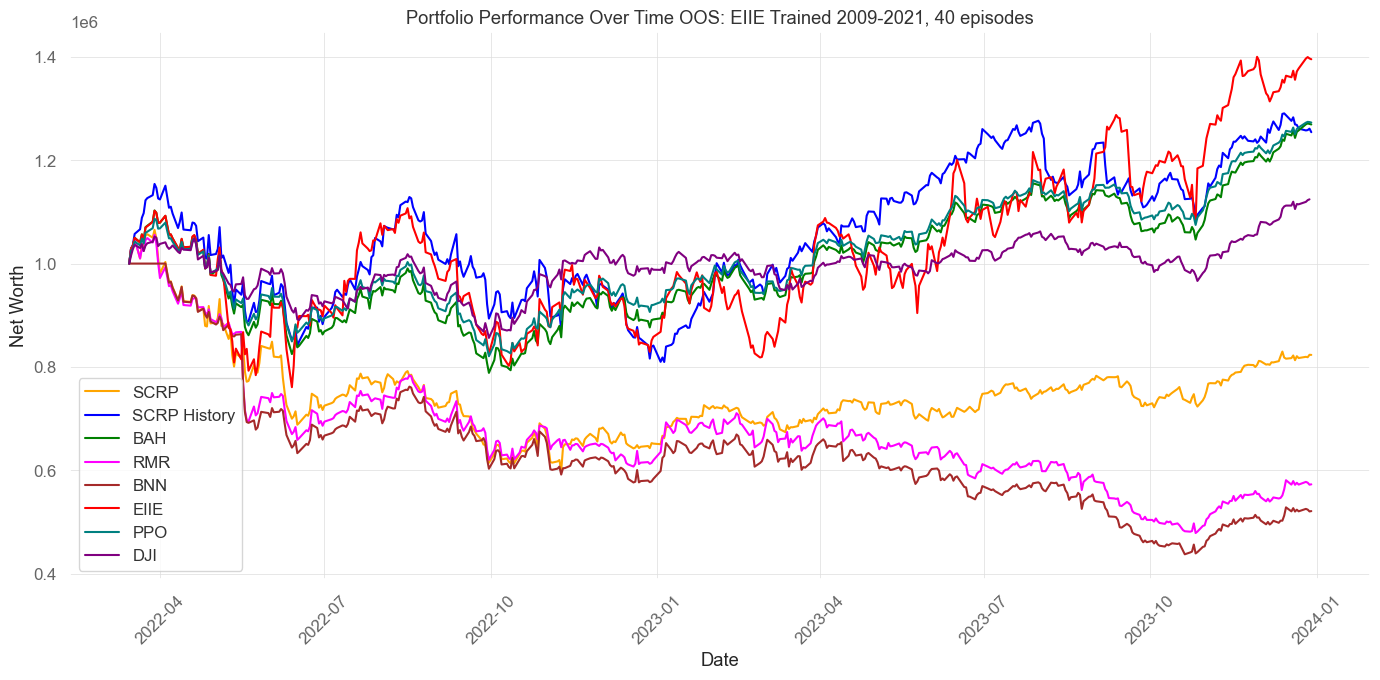

In [27]:
# Use the correct backend for Jupyter
%matplotlib inline
import matplotlib.pyplot as plt

# TODO make sure all dates line up, fix CRP and OLMAR 

import matplotlib.pyplot as plt

# Define a color map for the labels
color_map = {
    'BAH': 'green',
    'EIIE': 'red',
    'PPO': 'teal',
    'DJI': 'purple',
    'SCRP': 'orange',
    'SCRP History': 'blue',
    'OLMAR': 'cyan',
    'RMR': 'magenta',
    'BNN': 'brown'
}




plt.figure(figsize=(14, 7))
# plt.plot(merged_df['Date'], merged_df['crp_opt_net_worth'], label='CRP', color=color_map['CRP'])
plt.plot(merged_df['Date'], merged_df['scrp_opt_net_worth'], label='SCRP', color=color_map['SCRP'])
plt.plot(merged_df['Date'], merged_df['scrp_hist_opt_net_worth'], label='SCRP History', color=color_map['SCRP History'])
plt.plot(merged_df['Date'], merged_df['bah_opt_net_worth'], label='BAH', color=color_map['BAH'])
# plt.plot(merged_df['Date'], merged_df['olmar_opt_net_worth'], label='OLMAR', color=color_map['OLMAR'])
plt.plot(merged_df['Date'], merged_df['rmr_opt_net_worth'], label='RMR', color=color_map['RMR'])
plt.plot(merged_df['Date'], merged_df['bnn_opt_net_worth'], label='BNN', color=color_map['BNN'])
plt.plot(merged_df['Date'], merged_df['eiie_net_worth'], label='EIIE', color=color_map['EIIE'])
plt.plot(merged_df['Date'], merged_df['ppo_opt_net_worth'], label='PPO', color=color_map['PPO'])
plt.plot(merged_df['Date'], merged_df['dji'], label='DJI', color=color_map['DJI'])
plt.xlabel('Date')
plt.ylabel('Net Worth')
plt.title('Portfolio Performance Over Time OOS: ' + GRAPH_TITLE)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
import pprint

final_returns = {
   'BCRP OPT': merged_df['bcrp_opt_net_worth'].iloc[-1],
    'CRP': merged_df['crp_opt_net_worth'].iloc[-1],
    'SCRP': merged_df['scrp_opt_net_worth'].iloc[-1],
    'Hist. SCRP': merged_df['scrp_hist_opt_net_worth'].iloc[-1],
    'BAH': merged_df['bah_opt_net_worth'].iloc[-1],
    'OLMAR': merged_df['olmar_opt_net_worth'].iloc[-1],
    'RMR': merged_df['rmr_opt_net_worth'].iloc[-1],
    'BNN': merged_df['bnn_opt_net_worth'].iloc[-1],
    'EIIE': merged_df['eiie_net_worth'].iloc[-1],
    'PPO': merged_df['ppo_opt_net_worth'].iloc[-1],
}

pprint.pprint(final_returns)

{'BAH': 1268937.75,
 'BCRP OPT': 1451034.875,
 'BNN': 521506.4375,
 'CRP': 1312323.125,
 'EIIE': 1394971.75,
 'Hist. SCRP': 1253996.5,
 'OLMAR': 1031971.5,
 'PPO': 1272607.375,
 'RMR': 573255.4375,
 'SCRP': 823477.4375}


In [29]:
import numpy as np
import pprint

# Calculate the returns each day

# merged_df['BCRP_daily_return'] = merged_df['BCRP_net_worth'].pct_change()
# merged_df['CRP_daily_return'] = merged_df['CRP_net_worth'].pct_change()
merged_df['BCRP_opt_daily_return'] = merged_df['bcrp_opt_net_worth'].pct_change()
merged_df['CRP_opt_daily_return'] = merged_df['crp_opt_net_worth'].pct_change()
merged_df['SCRP_opt_daily_return'] = merged_df['scrp_opt_net_worth'].pct_change()
merged_df['SCRP_hist_opt_daily_return'] = merged_df['scrp_hist_opt_net_worth'].pct_change()


merged_df['BAH_opt_daily_return'] = merged_df['bah_opt_net_worth'].pct_change()
merged_df['OLMAR_opt_daily_return'] = merged_df['olmar_opt_net_worth'].pct_change()
merged_df['RMR_opt_daily_return'] = merged_df['rmr_opt_net_worth'].pct_change()
merged_df['BNN_opt_daily_return'] = merged_df['bnn_opt_net_worth'].pct_change()

merged_df['EIIE_daily_return'] = merged_df['eiie_net_worth'].pct_change()
merged_df['PPO_daily_return'] = merged_df['ppo_opt_net_worth'].pct_change()


# merged_df['OLMAR_daily_return'] = merged_df['OLMAR_net_worth'].pct_change()


# TODO need to put in the fama french

# Define the risk-free rate (annual, for example, 2%)
risk_free_rate = 0.02 / 252  # Convert annual risk-free rate to daily

# Define a function to calculate Sharpe ratio adjusted for the risk-free rate
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_return = returns - risk_free_rate
    mean_excess_return = excess_return.mean()
    std_excess_return = excess_return.std()
    annual_factor = np.sqrt(252)  # Assuming 252 trading days in a year
    sharpe_ratio = annual_factor * mean_excess_return / std_excess_return
    return sharpe_ratio

# Calculate the Sharpe ratio for each daily return column
sharpe_ratios = {
    # 'BCRP': calculate_sharpe_ratio(merged_df['BCRP_daily_return'], risk_free_rate),
    # 'CRP': calculate_sharpe_ratio(merged_df['CRP_daily_return'], risk_free_rate),
    'BCRP': calculate_sharpe_ratio(merged_df['BCRP_opt_daily_return'], risk_free_rate),
    'CRP': calculate_sharpe_ratio(merged_df['CRP_opt_daily_return'], risk_free_rate),
    'SCRP': calculate_sharpe_ratio(merged_df['SCRP_opt_daily_return'], risk_free_rate),
    'Hist. SCRP': calculate_sharpe_ratio(merged_df['SCRP_hist_opt_daily_return'], risk_free_rate),
    'BAH': calculate_sharpe_ratio(merged_df['BAH_opt_daily_return'], risk_free_rate),
    'OLMAR': calculate_sharpe_ratio(merged_df['OLMAR_opt_daily_return'], risk_free_rate),
    'RMR': calculate_sharpe_ratio(merged_df['RMR_opt_daily_return'], risk_free_rate),
    'BNN': calculate_sharpe_ratio(merged_df['BNN_opt_daily_return'], risk_free_rate),
    'EIIE': calculate_sharpe_ratio(merged_df['EIIE_daily_return'], risk_free_rate),
    'PPO': calculate_sharpe_ratio(merged_df['PPO_daily_return'], risk_free_rate),
    # 'OLMAR old': calculate_sharpe_ratio(merged_df['OLMAR_daily_return'], risk_free_rate),
    # 'Opt': calculate_sharpe_ratio(merged_df['opt_daily_return'], risk_free_rate),

}

pprint.pprint(sharpe_ratios)

{'BAH': 0.6336432814344716,
 'BCRP': 0.7269058919750453,
 'BNN': -1.2441896837248114,
 'CRP': 0.7081623575693407,
 'EIIE': 0.6143660228845517,
 'Hist. SCRP': 0.5129870655280288,
 'OLMAR': 0.1664392117125806,
 'PPO': 0.6999671083257923,
 'RMR': -1.046794074672463,
 'SCRP': -0.3768755376643949}


In [30]:
import pandas as pd
import numpy as np

# Assuming merged_df is your DataFrame
# Calculate the max drawdown for each specified column
def max_drawdown(series):
    cumulative_returns = series.cummax()
    drawdowns = series / cumulative_returns - 1
    max_drawdown_value = drawdowns.min()
    return max_drawdown_value

max_drawdowns = {
    # 'BCRP': max_drawdown(merged_df['BCRP_net_worth']),
    # 'CRP': max_drawdown(merged_df['CRP_net_worth']),
    'BCRP': max_drawdown(merged_df['bcrp_opt_net_worth']),
    'CRP': max_drawdown(merged_df['crp_opt_net_worth']),
    'SCRP': max_drawdown(merged_df['scrp_opt_net_worth']),
    'Hist. SCRP': max_drawdown(merged_df['scrp_hist_opt_net_worth']),
    'BAH': max_drawdown(merged_df['bah_opt_net_worth']),
    'OLMAR': max_drawdown(merged_df['olmar_opt_net_worth']),
    'RMR': max_drawdown(merged_df['rmr_opt_net_worth']),
    'BNN': max_drawdown(merged_df['bnn_opt_net_worth']),
    'EIIE': max_drawdown(merged_df['eiie_net_worth']),
    'PPO': max_drawdown(merged_df['ppo_opt_net_worth']),
    # 'Opt': max_drawdown(merged_df['opt_net_worth']),
}

pprint.pprint(max_drawdowns)


{'BAH': -0.2847578215810955,
 'BCRP': -0.376950127192349,
 'BNN': -0.5619737812500001,
 'CRP': -0.28321474024632254,
 'EIIE': -0.3094314221195408,
 'Hist. SCRP': -0.2982474489469831,
 'OLMAR': -0.41663492277301417,
 'PPO': -0.24465546842523345,
 'RMR': -0.5461667186683157,
 'SCRP': -0.43770561307033484}


In [31]:
import numpy as np
import pandas as pd

# Define a function to calculate the ratio of up days
def calculate_up_days_ratio(series):
    up_days = (series > 0).sum()
    total_days = series.count()
    return up_days / total_days if total_days > 0 else 0

# Calculate the ratio of up days for each daily return column
up_days_ratios = {
    'BCRP': calculate_up_days_ratio(merged_df['BCRP_opt_daily_return']),
    'CRP': calculate_up_days_ratio(merged_df['CRP_opt_daily_return']),
    'SCRP': calculate_up_days_ratio(merged_df['SCRP_opt_daily_return']),
    'Hist. SCRP': calculate_up_days_ratio(merged_df['SCRP_hist_opt_daily_return']),
    'BAH': calculate_up_days_ratio(merged_df['BAH_opt_daily_return']),
    'OLMAR': calculate_up_days_ratio(merged_df['OLMAR_opt_daily_return']),
    'RMR': calculate_up_days_ratio(merged_df['RMR_opt_daily_return']),
    'BNN': calculate_up_days_ratio(merged_df['BNN_opt_daily_return']),
    'EIIE': calculate_up_days_ratio(merged_df['EIIE_daily_return']),
    'PPO': calculate_up_days_ratio(merged_df['PPO_daily_return']),
}

pprint.pprint(up_days_ratios)




{'BAH': 0.5188470066518847,
 'BCRP': 0.5521064301552107,
 'BNN': 0.48558758314855877,
 'CRP': 0.5254988913525499,
 'EIIE': 0.5077605321507761,
 'Hist. SCRP': 0.5299334811529933,
 'OLMAR': 0.5099778270509978,
 'PPO': 0.532150776053215,
 'RMR': 0.49667405764966743,
 'SCRP': 0.5121951219512195}


In [32]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols


# TODO can we do a statisitical significance test with anova here?
ANOVA_cols = ['EIIE_daily_return', 'BAH_opt_daily_return']
cols = ['Date',] + ANOVA_cols


df_selected = merged_df[cols]

# Assuming merged_df is your DataFrame and daily returns have already been calculated
# Combine all return columns into one DataFrame for ANOVA
returns_long = df_selected.melt(
    id_vars=['Date'], 
    value_vars=ANOVA_cols,
    var_name='Portfolio', 
    value_name='Daily_Return'
)

# Remove any NaN values created by pct_change()
returns_long.dropna(inplace=True)

# Perform ANOVA
model = ols('Daily_Return ~ Portfolio', data=returns_long).fit()
anova_result = sm.stats.anova_lm(model, typ=2)

# Display the summary of the ANOVA
pprint.pprint(anova_result)

# The results do seem to be statisitcally significant


             sum_sq     df         F    PR(>F)
Portfolio  0.000042    1.0  0.103497  0.747748
Residual   0.366908  900.0       NaN       NaN


In [33]:
from scipy import stats

df_ppo = merged_df['EIIE_daily_return'].dropna() 
df_bah = merged_df['BAH_opt_daily_return'].dropna()

print(df_bah)

t_stat, p_value = stats.ttest_ind(df_ppo, df_bah) 

print(f"t-statistic: {t_stat}") 
print(f"p-value: {p_value}")

1      0.028380
2      0.005958
3      0.014793
4     -0.008515
5      0.015069
         ...   
447    0.002281
448    0.009353
449    0.001329
450   -0.000830
451   -0.000710
Name: BAH_opt_daily_return, Length: 451, dtype: float64
t-statistic: 0.32170906853551084
p-value: 0.747747809134339
